In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 函数式 API
Keras 函数式 API 是一种比 tf.keras.Sequential API 更加灵活的模型创建方式。函数式 API 可以处理具有**非线性拓扑的模型、具有共享层的模型，以及具有多个输入或输出的模型**。

深度学习模型通常是层的有向无环图 (DAG)。因此，函数式 API 是构建层计算图的一种方式。

In [2]:
inputs = keras.Input(shape=(784,))
inputs.shape

TensorShape([None, 784])

可以通过在此 inputs 对象上调用层，在层计算图中创建新的节点：

In [3]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)


“层调用”操作就像从“输入”向您创建的该层绘制一个箭头。您将输入“传递”到 dense 层，然后得到 x。

让我们为层计算图多添加几个层：

In [4]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


**您还可以将模型绘制为计算图：**


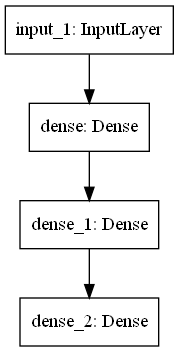

In [5]:
keras.utils.plot_model(model,'my_first_model.png')

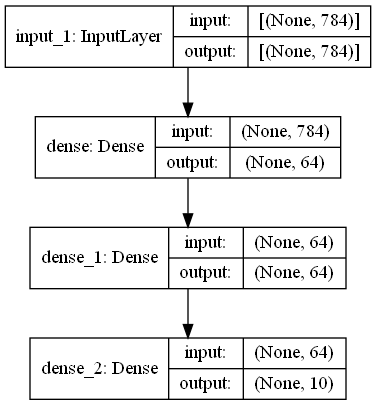

In [10]:
keras.utils.plot_model(model,'my_first_model.png',show_shapes=True)

加载 MNIST 图像数据，将其改造为向量，将模型与数据拟合（同时监视验证拆分的性能），然后在测试数据上评估模型：

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

# 保存和序列化

调用 model.save() 将整个模型保存为单个文件。

# 使用相同的层计算图定义多个模型

模型是通过在层计算图中指定其输入和输出来创建的。这意味着可以使用单个层计算图来生成多个模型。

在下面的示例中，您将使用相同的层堆栈来实例化两个模型：能够将图像输入转换为 16 维向量的 encoder 模型，以及用于训练的端到端 autoencoder 模型。

In [12]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

# 在encode_ouput的基础上进行了解码构造
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

# 所有模型均可像层一样调用
您可以通过在 Input 上或在另一个层的输出上调用任何模型来将其当作层来处理。通过调用模型，您不仅可以重用模型的架构，还可以重用它的权重。
为了查看实际运行情况，下面是对自动编码器示例的另一种处理方式，该示例创建了一个编码器模型、一个解码器模型，并在两个调用中将它们链接，以获得自动编码器模型：

In [13]:
# 编码器构造
encode_input=keras.Input(shape=(28, 28, 1), name="original_img")
x=layers.Conv2D(16, 3, activation="relu")(encode_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder=keras.Model(encode_input,encoder_output,name='encoder')
encoder.summary()
# 解码器构造
decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()



Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

如您所见，模型可以嵌套：模型可以包含子模型（因为模型就像层一样）。
模型嵌套的一个常见用例是装配。例如，以下展示了如何将一组模型装配成一个平均其预测的模型：

In [14]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)


# 处理复杂的计算图拓扑

函数式 API 使处理**多个输入和输出**变得容易。而这无法使用 Sequential API 处理。<br>
如果您要构建一个系统，该系统按照优先级对自定义问题工单进行排序，然后将工单传送到正确的部门，则此模型将具有三个输入：<br>

- 工单标题（文本输入），
- 工单的文本正文（文本输入），以及
- 用户添加的任何标签（分类输入）

此模型将具有两个输出：<br>

- 介于 0 和 1 之间的优先级分数（标量 Sigmoid 输出），以及
- 应该处理工单的部门（部门范围内的 Softmax 输出）。

您可以使用函数式 API 通过几行代码构建此模型：<br>

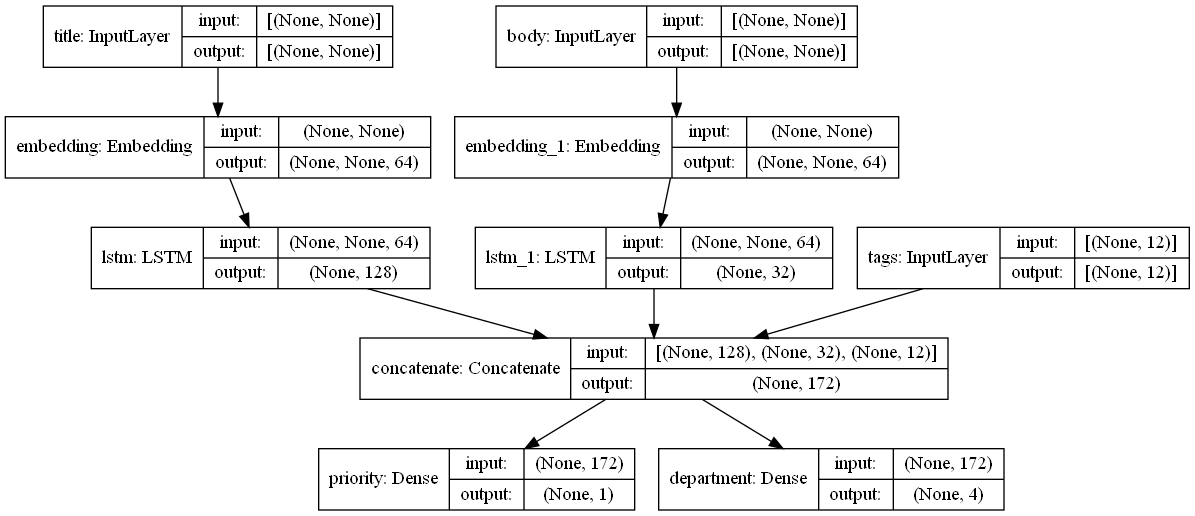

In [15]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])
# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)


# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


In [17]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
#         可以指定如下损失函数分别为多少
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)


Epoch 1/2
40/40 [==============================] - 5s 21ms/step - loss: 1.2686 - priority_loss: 0.7033 - department_loss: 2.8265
Epoch 2/2
40/40 [==============================] - 1s 21ms/step - loss: 1.2807 - priority_loss: 0.6993 - department_loss: 2.9066


# 共享层
共享层是在同一个模型中多次重用的层实例，它们会学习与层计算图中的多个路径相对应的特征。

共享层通常用于对来自相似空间（例如，两个具有相似词汇的不同文本）的输入进行编码。它们可以实现在这些不同的输入之间共享信息，以及在更少的数据上训练这种模型。如果在其中的一个输入中看到了一个给定单词，那么将有利于处理通过共享层的所有输入。

要在函数式 API 中共享层，请多次调用同一个层实例。

In [18]:
# 下面是一个在两个不同文本输入之间共享的 Embedding 层：
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)


# 提取和重用层计算图中的节点

由于要处理的层计算图是静态数据结构，可以对其进行访问和检查。而这就是将函数式模型绘制为图像的方式。

这也意味着您可以访问中间层的激活函数（计算图中的“节点”）并在其他地方重用它们，这对于特征提取之类的操作十分有用。

In [ ]:
vgg19 = tf.keras.applications.VGG19()
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)


 38076416/574710816 [>.............................] - ETA: 11:09

# 使用自定义层扩展 API

tf.keras 包含了各种内置层，例如：

- 卷积层：Conv1D、Conv2D、Conv3D、Conv2DTranspose
- 池化层：MaxPooling1D、MaxPooling2D、MaxPooling3D、AveragePooling1D
- RNN 层：GRU、LSTM、ConvLSTM2D
- BatchNormalization、Dropout、Embedding 等

但是，如果找不到所需内容，可以通过创建您自己的层来方便地扩展 API。所有层都会子类化 Layer 类并实现下列方法：

- call 方法，用于指定由层完成的计算。
- build 方法，用于创建层的权重（这只是一种样式约定，因为您也可以在 __init__ 中创建权重）。
- 请定义一个 get_config 方法，返回层实例的构造函数参数：


# 何时使用函数式 API

，函数式 API 更高级、更易用且更安全，并且具有许多子类化模型所不支持的功能。

但是，当构建不容易表示为有向无环的层计算图的模型时，模型子类化会提供更大的灵活性。
